In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import scipy.cluster
import shap

from dk_model import DeepKrigingTrainer


In [3]:
deposit_data = pd.read_csv("../Curated_data/final_dataset_1_no_0.csv", low_memory=False)


In [5]:
total_columns = ['CP_Total','PO_Total', 'PY_Total']

#all covariates
#covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm', 'Random_Values'] 

covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm'] 
phi_columns = deposit_data.columns[10:].tolist()

print(phi_columns[-1])

deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

deposit_data[phi_columns + covariates]

p = len(phi_columns) + len(covariates)

phi_487


In [6]:
covariates

['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']

# Deepkriging train test split

In [184]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

phi_columns = deposit_data.columns[10:-1].tolist()

torch.manual_seed(42)
np.random.seed(42)

p = len(phi_columns) + len(covariates)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(deposit_data[phi_columns + covariates],
                                                    deposit_data['Density_gcm3'],
                                                    test_size=0.2, random_state=42)

# Define the neural network
model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

# Training loop
for step in range(601):
    pre = model(torch.tensor(X_train.values, dtype=torch.float32))
    mse = mse_loss(pre, torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32))
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()


# Store metrics for this fold
test_predictions = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()

def print_metrics(true_values, predicted_values, dataset_name, p):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    print(f"{dataset_name} MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


# Print metrics for the test set
print_metrics(y_test.values, test_predictions, "Test", p)



Test MSE: 0.0022, MAE: 0.0324, R2: 0.8506


In [8]:
trainer_regular = DeepKrigingTrainer(deposit_data, covariates, regular_nn=False, plot_errors=False)
trainer_regular.train_neural_network(mode="regular", test_size=0.2)
test_predictions2 = trainer_regular.test_predictions


Average Metrics Across Folds:
  Average MSE: 0.0021
  Average MAE: 0.0328
  Average adjusted R2: -1.5496
  STD MSE: 0.0000
  STD MAE: 0.0000
  STD adjusted R2: 0.0000


In [11]:
X_phi = X_test.iloc[:, :len(phi_columns)]
X_phi

,phi_0,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,phi_9,...,phi_477,phi_478,phi_479,phi_480,phi_481,phi_482,phi_483,phi_484,phi_485,phi_486
2240,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
175,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000334,8.869446e-16,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1253,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1461,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2430,0.0,0.0,0.0,0.0,0.000027,0.000015,0.0,0.000137,0.038257,0.031329,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
482,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1032,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
438,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,1.658772e-14,0.000001,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
def select_columns(X_test, columns):
    if isinstance(columns, list):
        # Handle the case where columns is a list
        selected_columns = [col for col in X_test.columns if col not in columns]
    elif isinstance(columns, str):
        # Handle the case where columns is a single column name
        selected_columns = [col for col in X_test.columns if col != columns]
    else:
        # Handle invalid input
        raise ValueError("Invalid input for columns")
    return selected_columns

def filter(column):
    if isinstance(column, list):
        # Handle the case where column is a list
        X_column = X_test[column]
    elif isinstance(column, str):
        # Handle the case where column is a single column name
        X_column = X_test[[column]]
    else:
        # Handle invalid input
        raise ValueError("Invalid input for column")
    return X_column

In [206]:
import pandas as pd
from itertools import combinations
import math
torch.manual_seed(42)
np.random.seed(42)
# Create all possible combinations of columns and generate a new DataFrame for each combination
def subgroups2(column):
    X_column = filter(column)
    selected_columns = select_columns(X_test, column)
    X_column_c = X_test[selected_columns]
    covariates = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']
    covariates_minus_j = covariates.copy()
    covariates_minus_j.append(phi_columns)
    covariates_minus_j.remove(column)

    new_dataframes_column = []
    omega = 0
# The first loop goes over the number of selected columns
# The second loop goes over all the combinations of the selected columns 
    for r in range(0, len(covariates_minus_j)+1):
        power_set = combinations(covariates_minus_j, r)
        for combo in power_set:
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            S = pd.concat([new_df, X_column], axis=1)
            sorted_columns = X_test.columns.intersection(S.columns)
            S = S[sorted_columns]
            S_copy = S.copy()
            S_copy[column] = 0
            new_dataframes_column.append(S)
            new_dataframes_column.append(S_copy)

            pred_S = model(torch.tensor(S.values, dtype=torch.float32)).detach().numpy().flatten()
            pred_S_j = model(torch.tensor(S_copy.values, dtype=torch.float32)).detach().numpy().flatten()
            delta_j = pred_S - pred_S_j
            size_G = len(covariates) + 1
            G_fact = math.factorial(size_G)
            size_S = size_G - len(combo) - 1  
            weight = math.factorial(size_S)*math.factorial(size_G - size_S - 1)*(1/G_fact)
            omega += weight*delta_j

    return new_dataframes_column, omega

In [208]:
permus_phi, omega_phi = subgroups2(phi_columns)

In [207]:
for col in X_easy.columns.tolist():
    exec(f"permutations2_{col}, omega_{col} = subgroups2('{col}')")

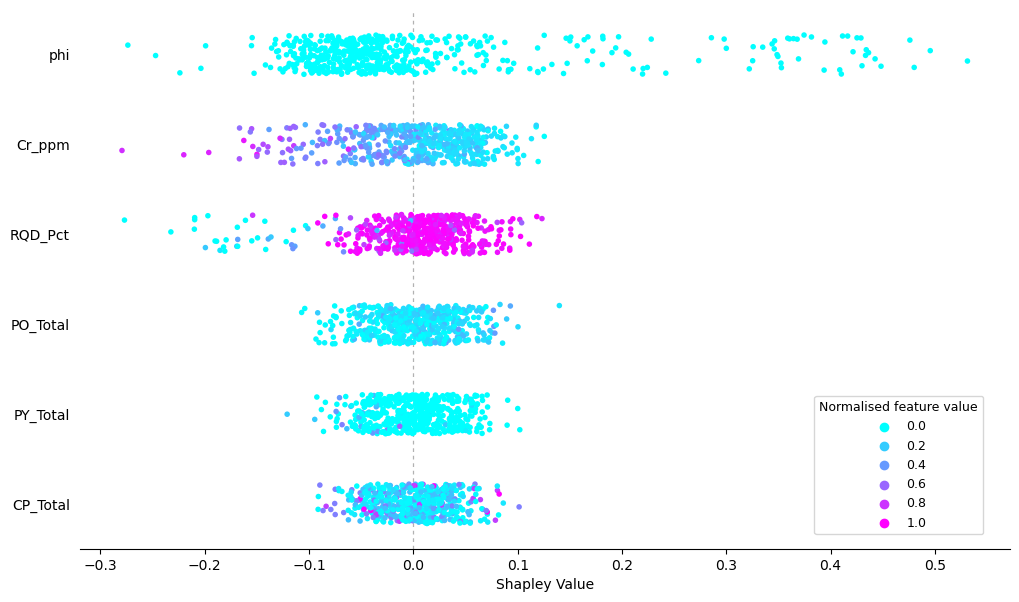

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

custom_colors = ["#00FFFF", "#FF00FF"]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', custom_colors)

df_sv = pd.DataFrame()
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']
df_sv['feature'] = sum([[feature] * len(X_test) for feature in features], [])
df_sv['shapley value'] = np.concatenate([omega_CP_Total, omega_PO_Total, omega_PY_Total, omega_RQD_Pct, omega_Cr_ppm])
df_sv['hue'] = np.concatenate([X_test[feature].values for feature in features])

mean_df = pd.DataFrame()
mean_df['Mean'] = X_phi.mean(axis=1)
df_sv_phi = pd.DataFrame()
df_sv_phi["feature"] = ["phi"] * len(X_test)
df_sv_phi["shapley value"] = omega_phi
df_sv_phi['hue'] = mean_df['Mean'].values

df_sv = pd.concat([df_sv, df_sv_phi])

# Calculate the absolute sum of Shapley values for each feature
abs_sum_shapley = df_sv.groupby('feature')['shapley value'].apply(lambda x: np.sum(np.abs(x)))
feature_order = abs_sum_shapley.sort_values(ascending=False).index

# Sort the DataFrame based on the feature order
df_sv['feature'] = pd.Categorical(df_sv['feature'], categories=feature_order, ordered=True)
df_sv = df_sv.sort_values('feature')

# Beeswarm plot with custom colors
fig, ax = plt.subplots(figsize=(12, 7))  # Set the figure size (width, height)
ax.axvline(0, c="grey", alpha=0.6, linewidth=0.9, linestyle='--', dashes=(3, 3))
sns.stripplot(
    x=df_sv['shapley value'],
    y=df_sv['feature'],
    hue=df_sv['hue'],
    palette=custom_cmap,
    size=4,
    linewidth=0,  # Set linewidth for edges
    jitter=0.22  # Set linewidth for edges
)
ax.spines.left.set_visible(False)
ax.set_ylabel("")

#ax.set_yticklabels([r'$\phi$', 'Pyrrhotite', 'Rock Quality', 'Chromium', 'Chalcopyrite', 'Pyrite'])


# Increase x-axis and y-axis tick font size
ax.tick_params(axis='x', labelsize=10)  # Adjust the labelsize as needed
ax.tick_params(axis='y', labelsize=10)  # Adjust the labelsize as needed
ax.set_xlabel("Shapley Value", fontsize=10)

# Increase overall legend font size
legend = plt.legend(title='Normalised feature value', loc='upper right', bbox_to_anchor=(0.978, 0.295), borderaxespad=0.5, fontsize='9')
legend.get_title().set_fontsize('9') 
ax.spines.right.set_visible(False)  # Remove the right spine
ax.spines.top.set_visible(False)    # Remove the top spine
ax.tick_params(left=False, bottom=True)

plt.show()


In [210]:
import pandas as pd


# FIX THIS, THE CONCATENATION ORDER IS NOT RIGHT

df_shapley = pd.DataFrame(X_test).reset_index(drop=True)

# Iterate over each unique feature
for feature_name in df_sv['feature'].unique():
    # Filter the DataFrame for the current feature
    filtered_df = df_sv.loc[df_sv['feature'] == feature_name].copy()
    
    filtered_df.columns = [f"{feature_name}-{col}" if col != 'feature' else col for col in filtered_df.columns]
    
    filtered_df = filtered_df.drop(columns=['feature']).reset_index(drop=True)
    
    df_shapley = pd.concat([df_shapley, filtered_df], axis=1)


df_shapley
df_shapley.to_csv('df_shapley.csv', index=False)

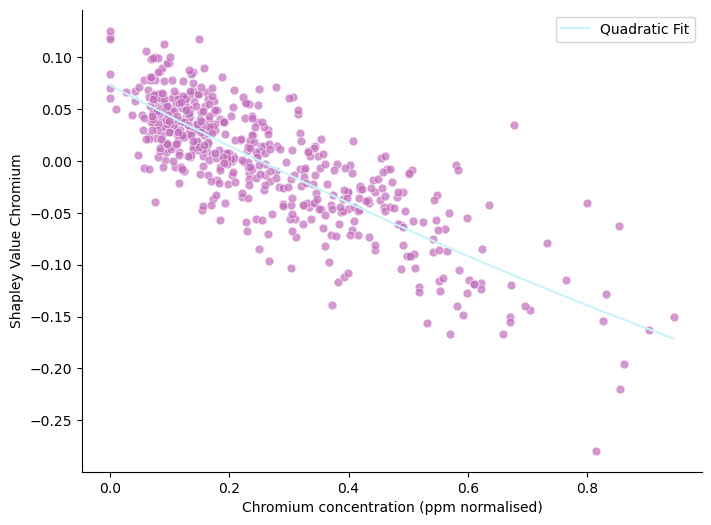

In [211]:
coefficients = np.polyfit(X_test['Cr_ppm'], omega_Cr_ppm, 2)
quadratic_curve = np.poly1d(coefficients)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test['Cr_ppm'], y=omega_Cr_ppm, s=40, alpha=0.7, color='#C26DBC')

x_values = np.linspace(min(X_test['Cr_ppm']), max(X_test['Cr_ppm']), 100)
plt.plot(x_values, quadratic_curve(x_values), color='#C8F4F9', linestyle='-', label='Quadratic Fit')

plt.xlabel('Chromium concentration (ppm normalised)', fontsize=10)
plt.ylabel('Shapley Value Chromium', fontsize=10)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.legend()  # Show legend
plt.savefig('Chromium dependence.png')  # Save the plot as PNG
plt.show()


In [254]:
import plotly.graph_objects as go
import pandas as pd



instance_idx = 120
instance_row = X_test.iloc[instance_idx]

df_waterfall_combined = pd.DataFrame()

features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'phi']

df_waterfall_combined['feature'] = features
df_waterfall_combined['shapley value'] = [
    omega_CP_Total[instance_idx],
    omega_PO_Total[instance_idx],
    omega_PY_Total[instance_idx],
    omega_RQD_Pct[instance_idx],
    omega_Cr_ppm[instance_idx],
    omega_phi[instance_idx]  
]
df_waterfall_combined['source'] = ['Shapley'] * len(df_waterfall_combined)

fig_waterfall_combined = go.Figure()

mean_prediction = test_predictions.mean()

bar_sums = df_waterfall_combined['shapley value'].cumsum()

for source, color in zip(['Shapley'], ['#00FFFF']):
    source_df = df_waterfall_combined[df_waterfall_combined['source'] == source]
    symbols = ['triangle-right' if val >= 0 else 'triangle-left' for val in source_df['shapley value']]
    fig_waterfall_combined.add_trace(
        go.Waterfall(
            name=f"waterfall_{source}",
            orientation="h",
            y=source_df['feature'],
            x=source_df['shapley value'],
            base=mean_prediction,  # Set the base value
            decreasing=dict(marker=dict(color='#FF00FF')),
            increasing=dict(marker=dict(color='#00FFFF')),
            connector=dict(line=dict(color='rgba(128, 128, 128, 0.5)', width=1, dash='dot')),  # Adjust connector appearance
        )
    )

fig_waterfall_combined.update_layout(
    #title="Waterfall Plot for Shapley Values (Single Instance)",
    width=1000, height=500, font=dict(size=14),
    paper_bgcolor='rgba(0,0,0,0)',  
    plot_bgcolor='rgba(0,0,0,0)',  
    xaxis=dict(
        tickfont=dict(size=12, family='sans-serif', color='black'),
          # Make the x-axis ticks same size and color as y-axis
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=[0, 1, 2, 3, 4, 5],
        ticktext=['Chalcopyrite', 'Pyrrhotite', 'Pyrite', 'Rock Quality', 'Chromium', '𝝓'],
        tickfont=dict(size=12, family='sans-serif', color='black') 
    ),
    annotations=[
        dict(
            x=mean_prediction,
            y=-0.13,
            xref='x',
            yref='paper',
            text=f"E[f(X)] = {mean_prediction:.3f}",
            showarrow=False,
            font=dict(size=12, color='grey'),  
        ),
        dict(
            x= mean_prediction + bar_sums.iloc[-1],  
            y=1.1,
            xref='x',
            yref='paper',
            text=f"f(X) = {(mean_prediction + bar_sums.iloc[-1]):.3f}",
            showarrow=False,
            font=dict(size=12, color='grey'),  
        )
    ]
)

fig_waterfall_combined.update_xaxes(ticks="outside")

fig_waterfall_combined.add_shape(
    type="line",
    x0=0.37,
    y0=0,
    x1=0.651 ,
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)


fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction + bar_sums.iloc[-1],
    y0=0,
    x1=mean_prediction + bar_sums.iloc[-1],
    y1=1,
    line=dict(color="grey", width=0.5, dash="dot"),
    xref="x",
    yref="paper",
)

fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction + bar_sums.iloc[-1],
    y0=-0.01,
    x1=mean_prediction + bar_sums.iloc[-1],
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)

fig_waterfall_combined.add_shape(
    type="line",
    x0=mean_prediction,
    y0=-0.01,
    x1=mean_prediction,
    y1=0,
    line=dict(color="grey", width=1),
    xref="x",
    yref="paper",
)


fig_waterfall_combined.write_html("waterfall.html")


In [255]:
test_predictions.mean()

0.4581261

In [256]:
test_predictions[instance_idx]

0.4431452

In [257]:
test_predictions[instance_idx]  - test_predictions.mean()

-0.014980912

In [258]:
df_waterfall_combined['shapley value'].sum()

-0.06557424